# Credit Risk Prediction

# Import Libraries

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score, f1_score

# Load Dataset

In [68]:
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

df = pd.read_csv('credit_risk_dataset.csv')

# Exploratory Data Analysis

In [69]:
# Show first 5 rows of the dataset
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [70]:
# Retrieve columns for categorical and continuous
indep_var_names = df.drop(['loan_grade'], inplace=False, axis=1).columns.tolist()
out_var_names = ['loan_grade']
cat_nom_var_col_names = ['person_home_ownership', 'loan_intent', 'loan_status', 'cb_person_default_on_file']

In [71]:
# Inspect DataFrame structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [72]:
# Summary statistics of the DataFrame
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [73]:
# Check for null values
df.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [74]:
# Check for class imbalance - Inform if stratification is needed when splitting data
df.loan_grade.value_counts(normalize=True)

loan_grade
A    0.330776
B    0.320770
C    0.198214
D    0.111292
E    0.029588
F    0.007397
G    0.001964
Name: proportion, dtype: float64

In [75]:
# Check for duplicates
print('No. of duplicates:' ,df.duplicated().sum())

No. of duplicates: 165


# Data Preprocessing

### Duplicates

In [76]:
# Drop Duplicates
df.drop_duplicates(inplace=True)
print('No. of duplicates:', df.duplicated().sum())

No. of duplicates: 0


### Null Values

In [77]:
# Inspect column containing nulls
for i in ['person_emp_length', 'loan_int_rate']:
    print(f'Value range of the variable {i}: {min(df[i])} - {max(df[i])}')

Value range of the variable person_emp_length: 0.0 - 123.0
Value range of the variable loan_int_rate: 5.42 - 23.22


In [78]:
# Since the min of 'person_emp_length' is 0, a null value most likely indicates missing values + Percentage is < 5% of the data; As such drop it
print(f'Percentage of NaN in person_emp_length: {((df.person_emp_length.isnull().sum() / len(df)) * 100):.2f}%')
print(f'Percentage of NaN in loan_int_rate: {((df.loan_int_rate.isnull().sum() / len(df)) * 100):.2f}%')

df.dropna(subset=['person_emp_length'], inplace=True)
df.person_emp_length.isnull().sum()

Percentage of NaN in person_emp_length: 2.74%
Percentage of NaN in loan_int_rate: 9.55%


0

In [79]:
# Print rows with null loan_int_rate
print(df[df.loan_int_rate.isnull()], '\n')

# Replacing NaN with 0, instead of dropping (since the minimum loan_amnt of all customers is $500 and there is no null value in the loan_amnt column)
df.loan_int_rate.fillna(0, inplace=True)

# Verification
print('Amount of null instances in `loan_int_rate` after fillna:', df.loan_int_rate.isnull().sum())

       person_age  person_income person_home_ownership  person_emp_length        loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length
39             23          71500                  RENT                3.0  DEBTCONSOLIDATION          D      30000            NaN            1                 0.42                         N                           4
50             24          78000                  RENT                4.0  DEBTCONSOLIDATION          D      30000            NaN            1                 0.38                         Y                           4
57             23         277000                   OWN                3.0           PERSONAL          A      35000            NaN            0                 0.13                         N                           4
59             24          12000                   OWN                2.0            VENTURE          E       1750            Na

/var/folders/j5/m90b2sqx6k9dr4l9ys0fgx300000gn/T/ipykernel_19190/3702821870.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.loan_int_rate.fillna(0, inplace=True)


### Encoding Outcome Variable (`loan_grade`)

In [80]:
loan_grade_order = [sorted(df.loan_grade.unique(), reverse=False)]
print('Loan Grade:', loan_grade_order)

encoder = OrdinalEncoder(dtype='int64', categories=loan_grade_order)
df['loan_grade'] = encoder.fit_transform(df[['loan_grade']])
df

Loan Grade: [['A', 'B', 'C', 'D', 'E', 'F', 'G']]


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,3,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,1,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,2,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,2,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,2,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,2,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,0,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,1,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,1,15000,11.48,0,0.10,N,26


### Encoding Categorical Variable

In [81]:
# Encoding Categorical Variables
print('Nominal Categorical Variables to be Encoded:', cat_nom_var_col_names)

Nominal Categorical Variables to be Encoded: ['person_home_ownership', 'loan_intent', 'loan_status', 'cb_person_default_on_file']


In [82]:
# # 'loan_status' is assigned the 'object' type; Do astype again to ensure correct data type
# df.loan_status = df.loan_status.astype('category').cat.codes
# print(df.dtypes)

In [83]:
# 'drop_first=True' for linear model
df_lm = pd.get_dummies(df, columns=cat_nom_var_col_names, drop_first=True, dtype='int64')
print('First 5 rows of df_lm:')
print(df_lm.head(), '\n')

# 'drop_first=False' for non-linear model
df_non_lm = pd.get_dummies(df, columns=cat_nom_var_col_names, drop_first=False, dtype='int64')
print('First 5 rows of df_nom_lm:')
print(df_non_lm.head())

First 5 rows of df_lm:
   person_age  person_income  person_emp_length  loan_grade  loan_amnt  loan_int_rate  loan_percent_income  cb_person_cred_hist_length  person_home_ownership_OTHER  person_home_ownership_OWN  person_home_ownership_RENT  loan_intent_EDUCATION  loan_intent_HOMEIMPROVEMENT  loan_intent_MEDICAL  loan_intent_PERSONAL  loan_intent_VENTURE  loan_status_1  cb_person_default_on_file_Y
0          22          59000              123.0           3      35000          16.02                 0.59                           3                            0                          0                           1                      0                            0                    0                     1                    0              1                            1
1          21           9600                5.0           1       1000          11.14                 0.10                           2                            0                          1                           0 

In [84]:
df_lm.dtypes

person_age                       int64
person_income                    int64
person_emp_length              float64
loan_grade                       int64
loan_amnt                        int64
loan_int_rate                  float64
loan_percent_income            float64
cb_person_cred_hist_length       int64
person_home_ownership_OTHER      int64
person_home_ownership_OWN        int64
person_home_ownership_RENT       int64
loan_intent_EDUCATION            int64
loan_intent_HOMEIMPROVEMENT      int64
loan_intent_MEDICAL              int64
loan_intent_PERSONAL             int64
loan_intent_VENTURE              int64
loan_status_1                    int64
cb_person_default_on_file_Y      int64
dtype: object

In [85]:
df_non_lm.dtypes

person_age                          int64
person_income                       int64
person_emp_length                 float64
loan_grade                          int64
loan_amnt                           int64
loan_int_rate                     float64
loan_percent_income               float64
cb_person_cred_hist_length          int64
person_home_ownership_MORTGAGE      int64
person_home_ownership_OTHER         int64
person_home_ownership_OWN           int64
person_home_ownership_RENT          int64
loan_intent_DEBTCONSOLIDATION       int64
loan_intent_EDUCATION               int64
loan_intent_HOMEIMPROVEMENT         int64
loan_intent_MEDICAL                 int64
loan_intent_PERSONAL                int64
loan_intent_VENTURE                 int64
loan_status_0                       int64
loan_status_1                       int64
cb_person_default_on_file_N         int64
cb_person_default_on_file_Y         int64
dtype: object

# Data Visualization

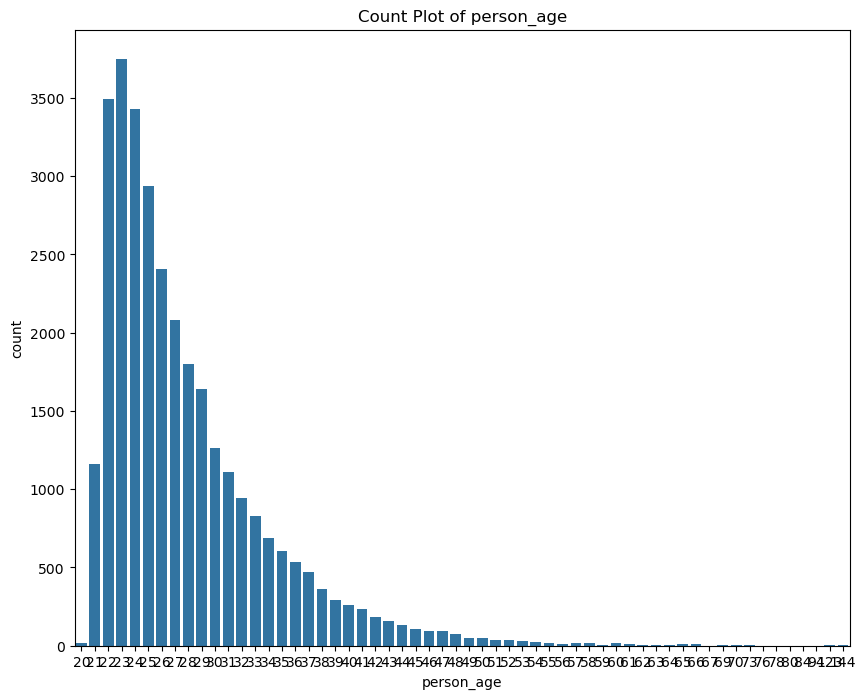

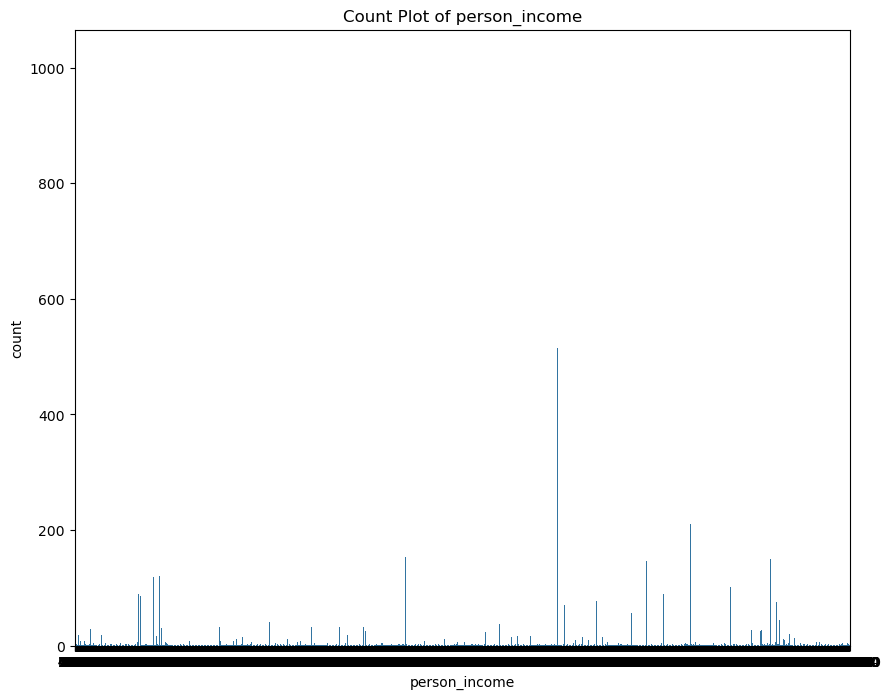

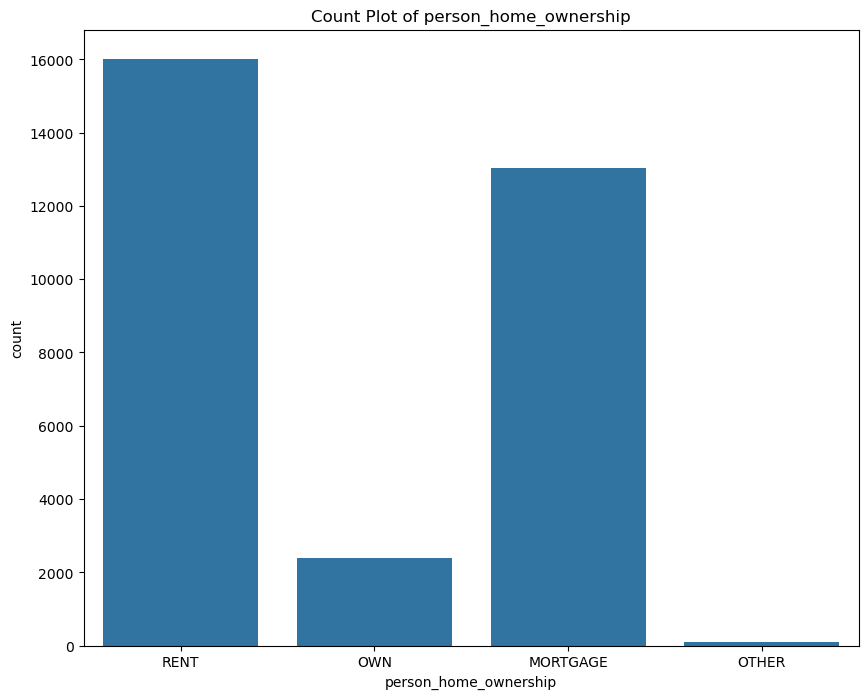

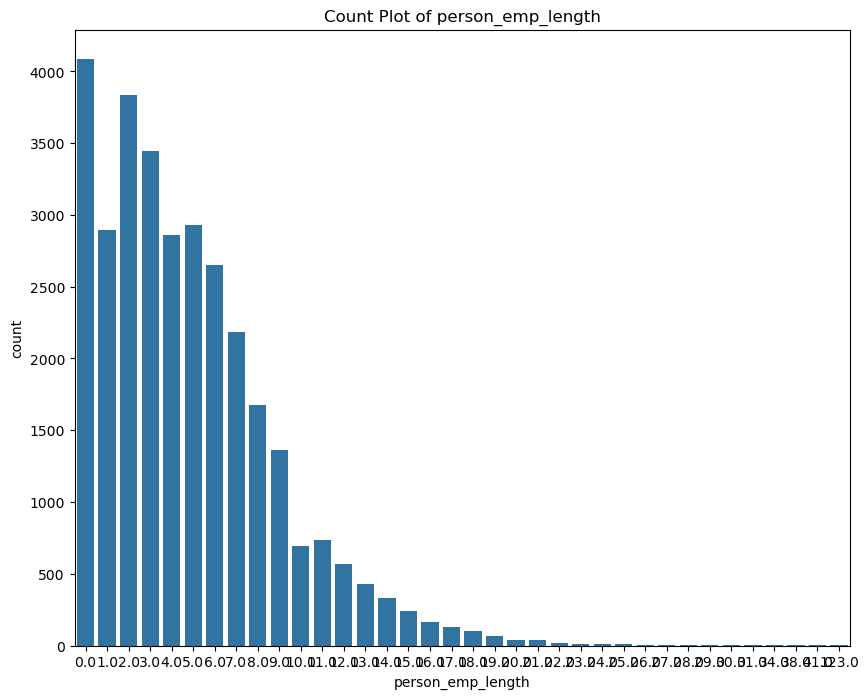

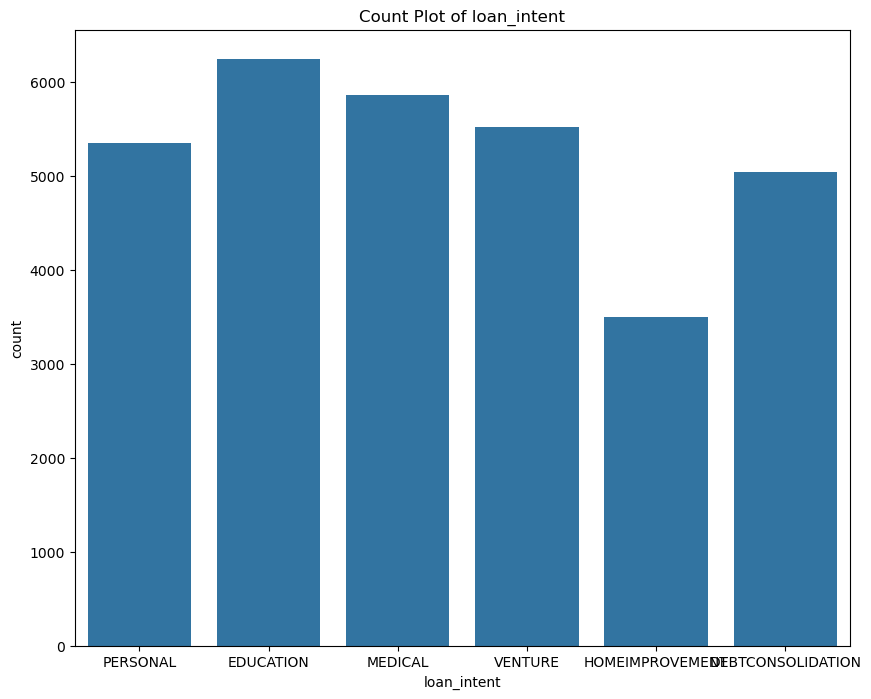

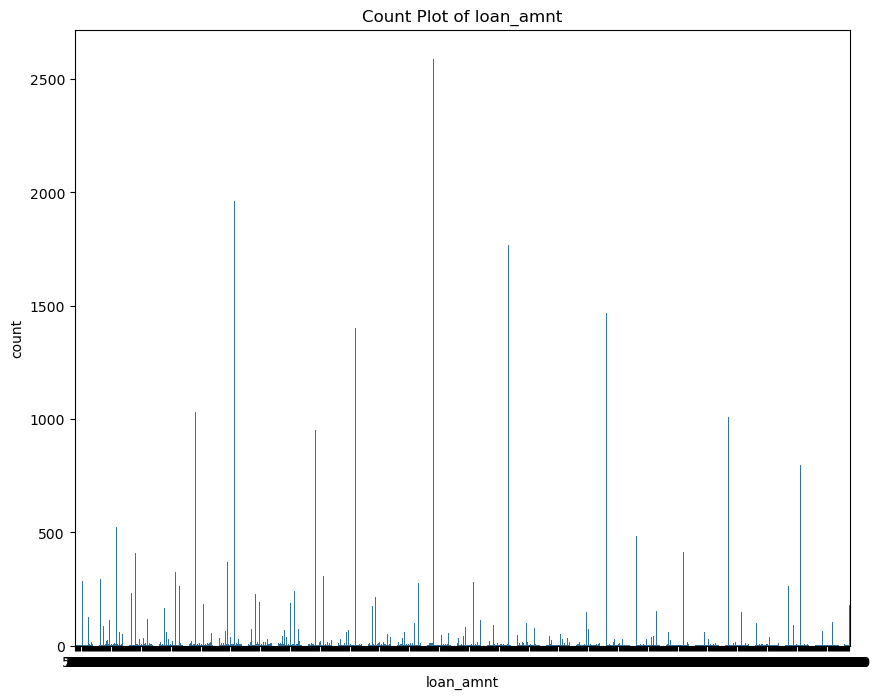

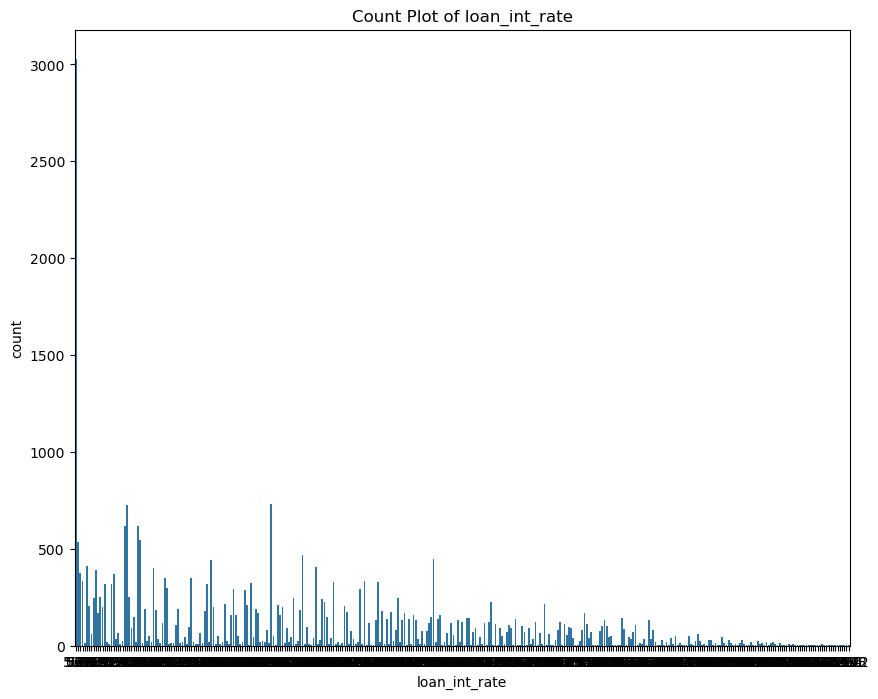

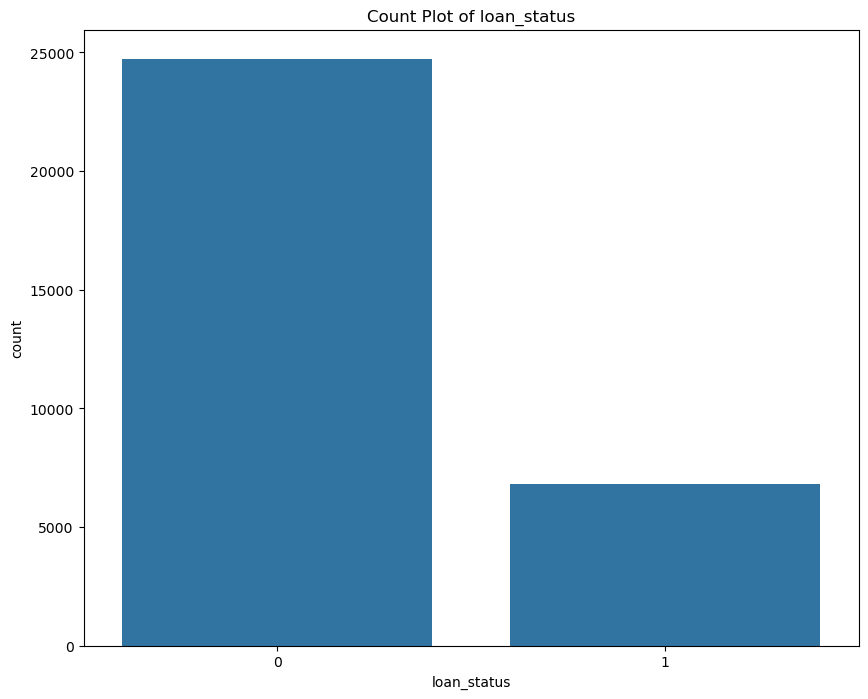

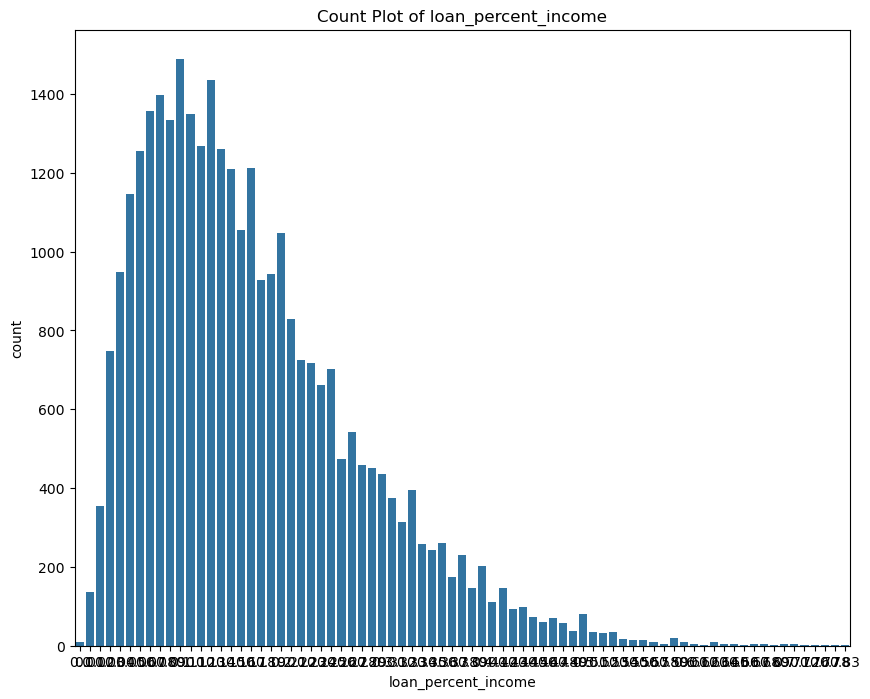

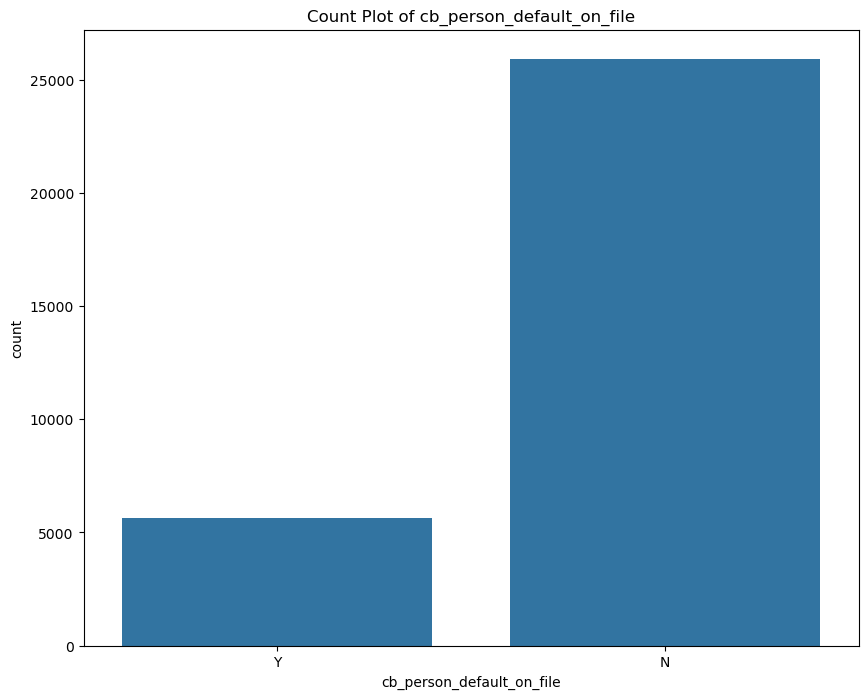

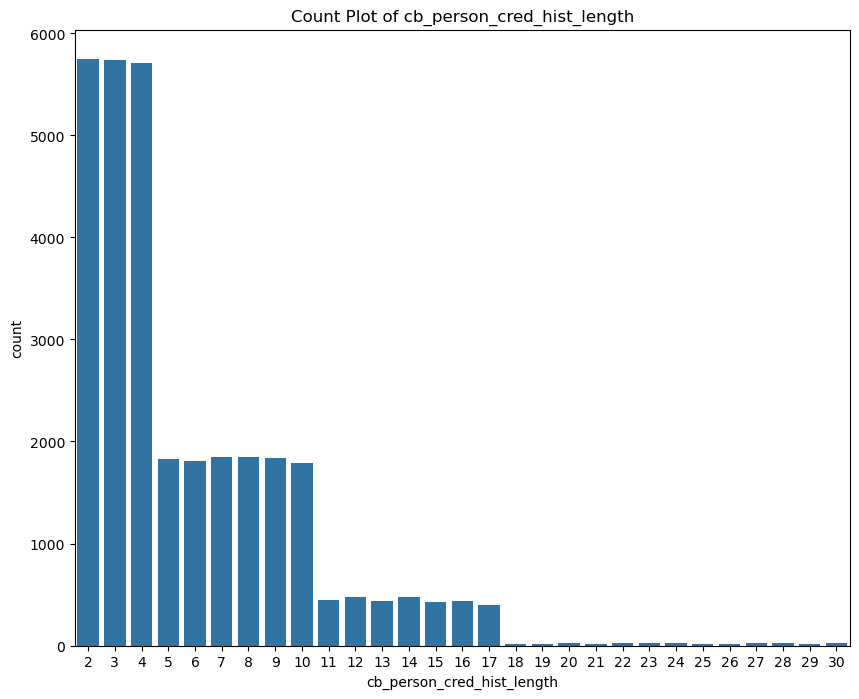

In [86]:
for var in indep_var_names:
    axes, fig = plt.subplots(figsize=(10, 8))
    sns.countplot(x=var, data=df)
    plt.title(f'Count Plot of {var}')
    plt.show()

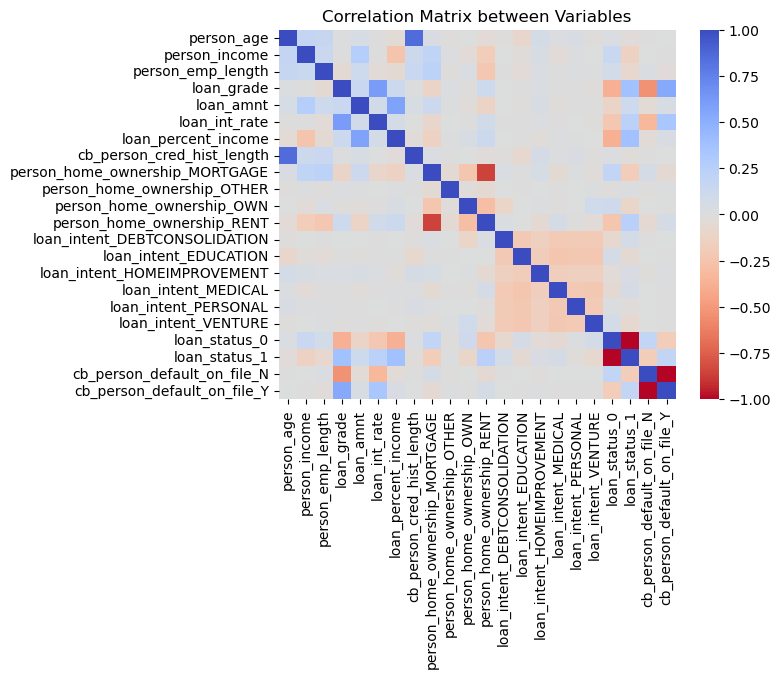

In [87]:
plt.figure()
sns.heatmap(df_non_lm.corr(), cmap="coolwarm_r", cbar=True)
plt.title('Correlation Matrix between Variables')
plt.show()

# ML Classification Models Training
* Logistic Regression $^1$
* SVM $^1$
* KNN $^1$
* Decision Tree (Without finetuning, Bagging, and Boosting respectively)
* Extra Trees (Random Best Split)
* Bagging Trees (Bootstrapping)
* Random Forest (Bagging + Random Best Split)
* XGBoost
* CatBoost
* LightGBM  

*$^1$ Standardization of data required*

In [88]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

### Define Train-Test Set Function

In [89]:
def data_splitter(model_name):
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    
    global df, df_lm, df_non_lm

    # Dependent variable y
    y = df.loan_grade

    # If model equals to any of the following, use the dataset that is tailored to them (i.e., df_lm), which contains "drop_fist=True" when doing OHE
    if model_name == 'LogisticRegression':
        X = df_lm.drop(['loan_grade'], axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8, test_size=0.2, stratify=y) # Stratify=True as there is imbalance in outcome variable

        # Standardization required for regularized logistic regression
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    else:
        X = df_non_lm.drop(['loan_grade'], axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8, test_size=0.2, stratify=y) # Stratify=True as there is imbalance in outcome variable

        # Standardization required for distance-based model
        if model_name in ['SVC', 'KNeighborsClassifier']:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

        # # # Convert the scaled data back to a DataFrame (if necessary for data inspection); Make sure to return 'scaled_df' at the end
        # scaled_df = pd.DataFrame(X_train, columns=X.columns)
    
    return X_train, X_test, y_train, y_test

In [90]:
# Verification of split
X_train, X_test, y_train, y_test = data_splitter('LogisticRegression')
print(len(X_train), len(X_test), len(y_train), len(y_test))
print(X_train, X_test, y_train, y_test)

25223 6306 25223 6306
[[-0.43286725 -0.02695091 -1.16538637 ... -0.46416496 -0.52414295
  -0.46618264]
 [ 0.19906507  0.81060281 -0.6786009  ... -0.46416496 -0.52414295
  -0.46618264]
 [-0.7488334  -0.4533419   0.53836276 ... -0.46416496 -0.52414295
  -0.46618264]
 ...
 [ 0.35704815 -0.4228854   0.29497003 ... -0.46416496 -0.52414295
  -0.46618264]
 [-1.06479956 -0.65258831 -0.6786009  ... -0.46416496 -0.52414295
  -0.46618264]
 [ 0.04108199  0.50597691  0.29497003 ...  2.15440647 -0.52414295
   2.14508202]] [[-0.27488417 -0.2401464   1.26854096 ... -0.46416496 -0.52414295
  -0.46618264]
 [ 2.09486201 -0.17923341 -0.19181544 ... -0.46416496 -0.52414295
  -0.46618264]
 [ 0.83099738  0.73446156  1.02514823 ... -0.46416496 -0.52414295
   2.14508202]
 ...
 [-0.27488417  0.88674406 -0.92199363 ... -0.46416496 -0.52414295
   2.14508202]
 [ 0.19906507  0.11010333 -0.43520817 ... -0.46416496  1.90787647
  -0.46618264]
 [ 0.04108199 -0.5081636   1.75532642 ... -0.46416496 -0.52414295
  -0.46618

### Define Model Function

In [91]:
def train_classifier(clf, X_train, X_test, y_train, y_test):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    model_dict = {
        'LogisticRegression': LogisticRegression(max_iter=1000), # Didn't converge when max_iter = 100 (default); default: {penalty='l2', C=1.0, solver='lbfgs', max_iter=100}
        'SVC': SVC(), # default: {C=1.0, kernel='rbf', degree=3}
        'KNeighborsClassifier': KNeighborsClassifier(), # default: {n_neighbors=5, p=2, metric='minkowski'}
        'DecisionTreeClassifier': DecisionTreeClassifier(), # default: {criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_leaf_nodes=None, min_impurity_decrease=0.0, ccp_alpha=0.0}
        'BaggingClassifier': BaggingClassifier(), # default: {estimator=None, n_estimators=10, bootstrap=True}
        'ExtraTreesClassifier': ExtraTreesClassifier(), # default: {criterion='gini', n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_leaf_nodes=None, min_impurity_decrease=0.0, ccp_alpha=0.0}
        'RandomForestClassifier': RandomForestClassifier(), # default: {criterion='gini', n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_leaf_nodes=None, min_impurity_decrease=0.0, ccp_alpha=0.0}
        'AdaBoostClassifier': AdaBoostClassifier(), # default: {estimator=None, n_estimators=50, learning_rate=1.0}
        'XGBClassifier': XGBClassifier(),
        'CatBoostClassifier': CatBoostClassifier(),
        'LGBMClassifier': LGBMClassifier()
    }

    clf = model_dict[clf]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Since the outcome variable is multiclass and imbalance, specify average='weighted' in precision_score and recall_score
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted') # Equivalent to Sensitivity (aka True Positive Rate)
    f1_score = f1_score(y_test, y_pred, average='weighted')

    # tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # specificity = tn / (tn + fp) # Equivalent to True Negative Rate

    return accuracy, precision, recall, f1_score

In [92]:
model_performance = {
    'LogisticRegression': [],
    'SVC': [],
    'KNeighborsClassifier': [],
    'DecisionTreeClassifier': [],
    'BaggingClassifier': [],
    'ExtraTreesClassifier': [],
    'RandomForestClassifier': [],
    'AdaBoostClassifier': [],
    'XGBClassifier': [],
    'CatBoostClassifier': [],
    'LGBMClassifier': []
}

for model in model_performance.keys():
    X_train, X_test, y_train, y_test = data_splitter(model)
    accuracy, precision, recall, f1_score = train_classifier(model, X_train, X_test, y_train, y_test)
    model_performance[model].append(accuracy)
    model_performance[model].append(precision)
    model_performance[model].append(recall)
    model_performance[model].append(f1_score)

model_performance_df = pd.DataFrame(model_performance, index=['Accuracy', 'Precision', 'Recall', 'F1 Score'])

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: P

Learning rate set to 0.093286
0:	learn: 1.5735453	total: 5.17ms	remaining: 5.17s
1:	learn: 1.3517228	total: 10.4ms	remaining: 5.2s
2:	learn: 1.1979183	total: 15.6ms	remaining: 5.19s
3:	learn: 1.0825862	total: 20.6ms	remaining: 5.13s
4:	learn: 0.9871224	total: 25.2ms	remaining: 5.02s
5:	learn: 0.9098047	total: 30.3ms	remaining: 5.02s
6:	learn: 0.8469302	total: 35.7ms	remaining: 5.06s
7:	learn: 0.7931844	total: 40.7ms	remaining: 5.05s
8:	learn: 0.7460627	total: 45.7ms	remaining: 5.04s
9:	learn: 0.7027995	total: 50.8ms	remaining: 5.03s
10:	learn: 0.6661855	total: 56ms	remaining: 5.04s
11:	learn: 0.6339757	total: 61.1ms	remaining: 5.03s
12:	learn: 0.6073086	total: 65.9ms	remaining: 5s
13:	learn: 0.5815760	total: 70.7ms	remaining: 4.98s
14:	learn: 0.5588756	total: 76.2ms	remaining: 5s
15:	learn: 0.5398848	total: 81ms	remaining: 4.98s
16:	learn: 0.5224492	total: 85.8ms	remaining: 4.96s
17:	learn: 0.5075326	total: 90.7ms	remaining: 4.95s
18:	learn: 0.4914328	total: 95.8ms	remaining: 4.95s
19:

In [93]:
print(model_performance_df)

           LogisticRegression       SVC  KNeighborsClassifier  DecisionTreeClassifier  BaggingClassifier  ExtraTreesClassifier  RandomForestClassifier  AdaBoostClassifier  XGBClassifier  CatBoostClassifier  LGBMClassifier
Accuracy             0.701871  0.823819              0.715826                0.906914           0.918966              0.829845                0.869172            0.606882       0.905804            0.916112        0.885347
Precision            0.694098  0.806721              0.697321                0.906936           0.918255              0.820696                0.862955            0.539548       0.902936            0.915270        0.888758
Recall               0.701871  0.823819              0.715826                0.906914           0.918966              0.829845                0.869172            0.606882       0.905804            0.916112        0.885347
F1 Score             0.685870  0.810265              0.700335                0.906890           0.918171        

# Hyperparameter Tuning
Decision Tree is chosen due to easier interpretability over other models

In [94]:
X = df_non_lm.drop(['loan_grade'], axis=1)
y = df_non_lm.loan_grade

# Use DecisionTreeClassifier directly
dtree_clf = DecisionTreeClassifier()

### Random Search

In [95]:
from scipy.stats import randint

# Define param_distributions
param_dist = {
    "max_depth": randint(3, 30),
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 20)
}

random_search = RandomizedSearchCV(
    dtree_clf, 
    param_distributions=param_dist, 
    n_iter=50,  # Search over 50 random combinations
    cv=5, 
    scoring="accuracy",
    random_state=42,
)

random_search.fit(X_train, y_train)

# Best parameters from RandomizedSearchCV
print("Best Parameters from RandomizedSearchCV:", random_search.best_params_)

Best Parameters from RandomizedSearchCV: {'max_depth': 13, 'min_samples_leaf': 4, 'min_samples_split': 9}


### Grid Search

In [96]:
from sklearn.metrics import f1_score as f1_metric

# Define multi-class scorers
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1_score': make_scorer(f1_metric, average='weighted')
}

# Parameter grid for DecisionTreeClassifier
param_grid = {
    'max_depth': [random_search.best_params_['max_depth'] + i for i in range(-2, 3)], # If random_search.best_params_['max_depth'] = 13, then we generate a range of values nearby 13 +/- 2
    'min_samples_split': [random_search.best_params_['min_samples_split'] + i for i in range(-2, 3)],
    'min_samples_leaf': [random_search.best_params_['min_samples_leaf'] + i for i in range(-2, 3)]
}

gs = GridSearchCV(estimator=dtree_clf, param_grid=param_grid, scoring=scoring, cv=5, refit='accuracy')
gs.fit(X, y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [11, 12, 13, 14, 15],
                         'min_samples_leaf': [2, 3, 4, 5, 6],
                         'min_samples_split': [7, 8, 9, 10, 11]},
             refit='accuracy',
             scoring={'accuracy': 'accuracy',
                      'f1_score': make_scorer(f1_score, response_method='predict', average=weighted),
                      'precision': make_scorer(precision_score, response_method='predict', average=weighted),
                      'recall': make_scorer(recall_score, response_method='predict', average=weighted)})

### Retrieve Best Parameters

In [97]:
# Best estimator
best_model = gs.best_estimator_
best_val_score = gs.best_score_
best_param = gs.best_params_

print(f'Best Model: {best_model}')
print(f'Best Validation Score: {best_val_score}')
print(f'Best Parameters: {best_param}')

Best Model: DecisionTreeClassifier(max_depth=14, min_samples_leaf=2, min_samples_split=9)
Best Validation Score: 0.9181070455664118
Best Parameters: {'max_depth': 14, 'min_samples_leaf': 2, 'min_samples_split': 9}


# Final Model Training

In [98]:
X_train, X_test, y_train, y_test = data_splitter('DecisionTreeClassifier')

best_dtree = DecisionTreeClassifier(max_depth=best_param['max_depth'], min_samples_leaf=best_param['min_samples_leaf'], min_samples_split=best_param['min_samples_split'])
best_dtree.fit(X_train, y_train)
y_pred = best_dtree.predict(X_test)

print('Acccuracy Score:', accuracy_score(y_test, y_pred))
print('Precision Score:', precision_score(y_test, y_pred, average='weighted'))
print('Recall Score:', recall_score(y_test, y_pred, average='weighted'))
print('F1 Score:', f1_metric(y_test, y_pred, average='weighted'))

Acccuracy Score: 0.9146844275293371
Precision Score: 0.9137925373366999
Recall Score: 0.9146844275293371
F1 Score: 0.9136223626289263


# Saving Model

In [99]:
import joblib

# Save the model
joblib.dump(best_dtree, 'decision_tree.pkl')
print("Model saved successfully!")

trainset_columns = X_train.columns
joblib.dump(trainset_columns, 'model_columns.pkl')
print("Train set column saved successfully!")

Model saved successfully!
Train set column saved successfully!
